In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cvxpy as cp

In [3]:
data_1 = np.load('data_1.npy')
data_2 = np.load('data_2.npy')
data_3 = np.load('data_3.npy')

print(data_1.shape)

(10, 2, 3)


In [4]:
# Maximum Likelihood Estimate

def MLE(data):
    # Define the transition matrix
    transition_matrix_pred = []
    
    time_steps = data.shape[1]
    
    for i in range(time_steps - 1):
        curr_pop = data[:, i+1].T
        prev_pop = data[:, i].T
        
        n_states = curr_pop.shape[0]
        
        P = cp.Variable((n_states, n_states))
        
        print(P.shape)
        
        vector_1 = np.ones((n_states, 1))
        
        # Define the optimization problem
        objective = cp.Minimize(cp.sum_squares(curr_pop - P.T @ prev_pop))
        
        print(prev_pop.shape)
        constraints = [P @ vector_1 == vector_1, P <= 1, P >= 0]
        
        prob = cp.Problem(objective, constraints)
        print("Optimal value", prob.solve())
        
        print("Predicted Transition Matrix: ", P.value)
        transition_matrix_pred.append(P.value)
    
    return np.array(transition_matrix_pred)

transition_matrix_pred_1 = MLE(data_1)
transition_matrix_pred_2 = MLE(data_2)
transition_matrix_pred_3 = MLE(data_3)

(3, 3)
(3, 10)
Optimal value 10939.144923581494
Predicted Transition Matrix:  [[0.29968168 0.09851736 0.60180096]
 [0.09592516 0.29056352 0.61351132]
 [0.09186741 0.10293638 0.80519621]]
(3, 3)
(3, 10)
Optimal value 14081.016691664192
Predicted Transition Matrix:  [[0.10785738 0.40680085 0.48534177]
 [0.09452576 0.49602816 0.40944608]
 [0.100051   0.30083498 0.59911402]]
(3, 3)
(3, 10)
Optimal value 3677.678601999749
Predicted Transition Matrix:  [[0.1473242  0.05714102 0.79553478]
 [0.04316412 0.13907066 0.81776522]
 [0.05186115 0.0422907  0.90584815]]


In [5]:
# Evaluate how close the prediction is to the original data
# Evaluation metric Implementation: WAPE for obtaining the average relative error

def error(data, transition_matrix_pred):
    true_final = data[:, 1].T
    
    # Predicted final population
    prev_pop = data[:, 0].T
    pred_final = transition_matrix_pred.T @ prev_pop
    
    relative_error = np.abs(true_final - pred_final) / true_final
    
    return np.average(relative_error)

relative_error_1 = error(data_1, transition_matrix_pred_1.reshape((3, 3)))
relative_error_2 = error(data_2, transition_matrix_pred_2.reshape((3, 3)))
relative_error_3 = error(data_3, transition_matrix_pred_3.reshape((3, 3)))

In [6]:
# Intention of this class is to contain the transition matrix and different profit models for a particular time. This is used to 
# identify the profit, given the original populations

import import_ipynb

from ProfitModels import logistic_profit, quadratic_profit

class profit_time:
    def __init__(self, transition_matrix, num_locations, error, profit_param=None, profit_models = ["logistic", "logistic", "quadratic"], time = "12 PM"):
        self.time = time
        self.transition_matrix = transition_matrix
        self.error = error
        self.num_locations = num_locations
        
        # Defining the locations and their profit models
        self.merch_model = logistic_profit()
        self.food_model = logistic_profit()
        self.stage_model = quadratic_profit()
        
        self.merch_model.half_sat = 500
        self.merch_model.capacity = 1000
        self.merch_model.unit_profit = 40

        self.food_model.half_sat = 1250
        self.food_model.capacity = 3000
        self.food_model.unit_profit = 20

        self.stage_model.linear = 10
        self.stage_model.quadratic = 0.01
        
        # Storing the profit models for future calculations
        self.locations = [self.merch_model, self.food_model, self.stage_model]
        
    def profit(self, initial_population):
        # Evaluate the final populations
        
        final_population = self.transition_matrix.T @ initial_population
        
        print(final_population)
        
        # Evaluate the profit
        
        profit = 0
        
        for i in range(self.num_locations):
            profit += self.locations[i].profit(final_population[i])
            
        return profit
    
    def average_error(self, initial_population):
        total_error = 0
        final_population = self.transition_matrix.T @ initial_population
        
        for i in range(self.num_locations):
            total_error += self.locations[i].profit(self.error * final_population[i])
            
        return total_error
    

# Creating the profit_time models for based on the predictions

profit_1 = profit_time(transition_matrix_pred_1.reshape((3, 3)), 3, error = relative_error_1, time = "11 AM")
profit_2 = profit_time(transition_matrix_pred_2.reshape((3, 3)), 3, error = relative_error_2, time = "1 PM")
profit_3 = profit_time(transition_matrix_pred_3.reshape((3, 3)), 3, error = relative_error_3, time = "3 PM")

[ 487.47425329  492.01726199 2020.50848472]
[ 293.00570157 1345.87424134 1361.12005708]
[ 242.3494665   238.50238735 2519.14814615]
[ 243.73712664  246.00863099 1010.25424236]
[144.61716468 701.37916916 654.00366615]
[  96.01827807  137.3043169  1191.67740504]
[ 434.12638687  247.47672107 1318.39689206]
[200.36563065 821.40403159 978.23033776]
[ 141.89730385  144.49302711 1713.60966904]
[155.83479166 176.6615309  667.50367744]
[100.34502076 385.88440461 513.77057462]
[ 67.47494632  83.97275048 848.5523032 ]
[ 731.21137993  738.02589298 3030.76272708]
[ 457.5543862  1858.47893299 2183.96668081]
[ 312.47730183  276.79004548 3210.73265269]


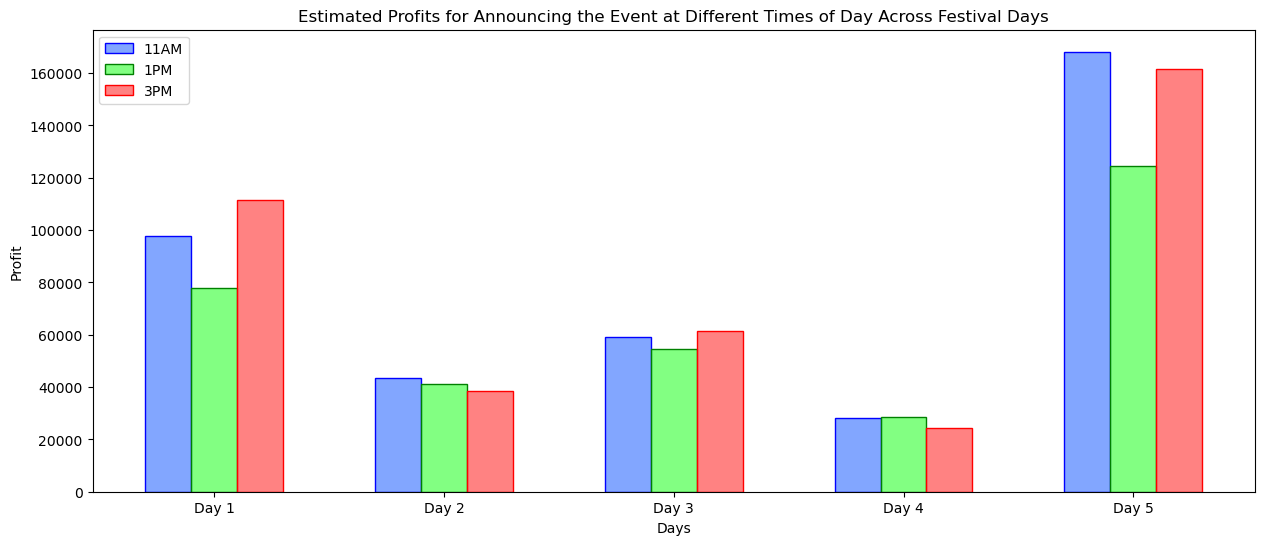

In [9]:
test_starting_populations = np.array([
    [1000, 1000, 1000],
    [500, 2000, 500],
    [1000, 1000, 1000],
    [500, 500, 500],
    [150, 1200, 150],
    [300, 750, 375],
    [1200, 250, 550], 
    [600, 800, 600], 
    [450, 550, 1000], 
    [300, 400, 300], 
    [250, 300, 450],
    [200, 400, 400],
    [1500, 1500, 1500],
    [2000, 1500, 1000], 
    [1300, 1000, 1500]
])


days = []
profits_11am = []
profits_1pm = []
profits_3pm = []

for i in range(int((test_starting_populations.shape[0])/3)):
    test_starting_population = test_starting_populations[3*i]

    profit_11am = profit_1.profit(test_starting_population)
    profits_11am.append(profit_11am)

    test_starting_population = test_starting_populations[3*i+1]
    
    profit_1pm = profit_2.profit(test_starting_population)
    profits_1pm.append(profit_1pm)

    test_starting_population = test_starting_populations[3*i+2]
    
    profit_3pm = profit_3.profit(test_starting_population)
    profits_3pm.append(profit_3pm)

    days.append(f"Day {i+1}")

x = np.arange(len(days))  # Number of days

bar_width = 0.2

color_11am = (0.3, 0.5, 1, 0.7)
color_1pm = (0.3, 1, 0.3, 0.7)
color_3pm = (1, 0.3, 0.3, 0.7)

plt.figure(figsize=(15, 6))

plt.bar(x - bar_width, profits_11am, width=bar_width, color=color_11am, edgecolor='blue', label='11AM')

plt.bar(x, profits_1pm, width=bar_width, color=color_1pm, edgecolor='green', label='1PM')

plt.bar(x + bar_width, profits_3pm, width=bar_width, color=color_3pm, edgecolor='red', label='3PM')

plt.xlabel('Days')
plt.ylabel('Profit')
plt.title('Estimated Profits for Announcing the Event at Different Times of Day Across Festival Days')
plt.xticks(x, days)
plt.legend()

plt.show()
